In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

/Users/praxal/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train=pd.read_csv("Downloads/train.csv")
test=pd.read_csv("Downloads/test.csv")

In [3]:
train.sample(6)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
17566,17567,NaN,"Korea, South",2020-04-17,10635.0,230.0
22528,22529,NaN,Panama,2020-05-04,7197.0,200.0
31611,31612,Oklahoma,US,2020-05-02,3851.0,238.0
11545,11546,NaN,Djibouti,2020-03-07,0.0,0.0
30211,30212,Mississippi,US,2020-04-12,2781.0,96.0
31311,31312,North Dakota,US,2020-02-22,0.0,0.0


In [4]:
test.sample(6)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
502763,id2394853,2,2016-02-08 07:59:00,6,-73.953987,40.766491,-73.975533,40.778610,N
119604,id1734363,1,2016-05-25 18:54:00,1,-73.970406,40.758553,-73.957062,40.780396,N
338068,id0298316,2,2016-03-25 10:44:07,2,-73.978638,40.755135,-73.994919,40.750092,N
348614,id2276592,1,2016-03-22 10:01:55,1,-73.958832,40.783337,-73.975533,40.789230,N
24016,id2188851,2,2016-06-23 18:24:27,1,-73.962997,40.772663,-73.968094,40.765347,N
352000,id1060305,1,2016-03-21 09:03:17,1,-73.863182,40.769226,-73.969009,40.760811,N


In [5]:
df = train.fillna('NA').groupby(['Country_Region','Province_State','Date'])['ConfirmedCases'].sum() \
                          .groupby(['Country_Region','Province_State']).max().sort_values() \
                          .groupby(['Country_Region']).sum().sort_values(ascending = False)

top10 = pd.DataFrame(df).head(10)
top10

,ConfirmedCases
Country_Region,
US,1442653.0
Russia,262843.0
United Kingdom,238005.0
Spain,230183.0
Italy,223885.0
Brazil,220291.0
France,179630.0
Germany,175233.0
Turkey,146457.0


In [14]:
df=train.groupby(['Date','Country_Region']).agg('sum').reset_index()
df.tail(5)

,Date,Country_Region,Id,ConfirmedCases,Fatalities
21155,2020-05-15,Vietnam,35535,314.0,0.0
21156,2020-05-15,West Bank and Gaza,35650,375.0,2.0
21157,2020-05-15,Western Sahara,35765,6.0,0.0
21158,2020-05-15,Zambia,35880,654.0,7.0
21159,2020-05-15,Zimbabwe,35995,42.0,4.0


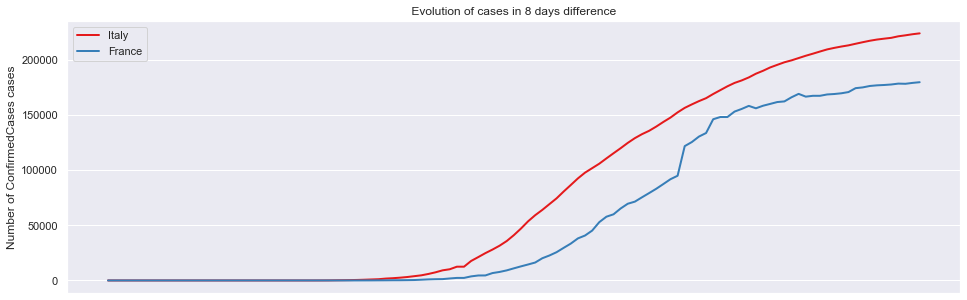

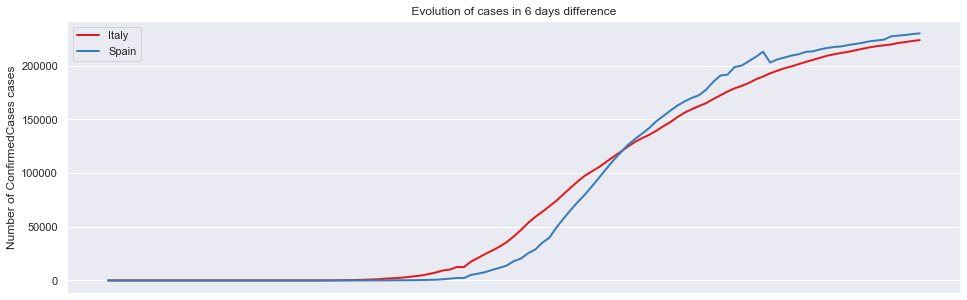

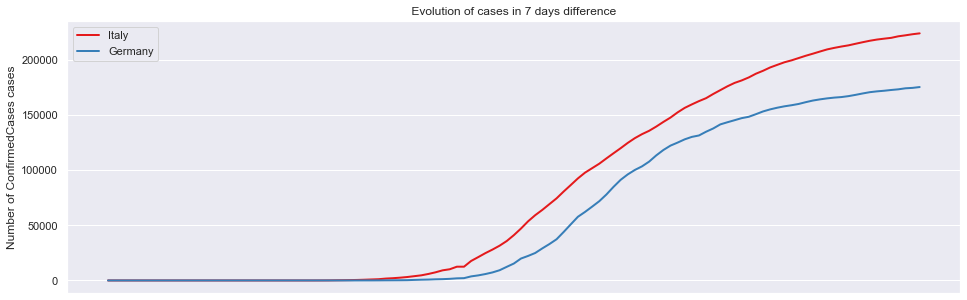

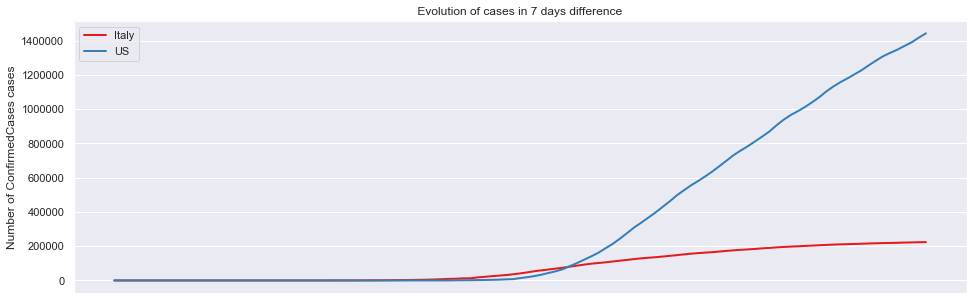

In [123]:
timeCompare(8,'Italy','France')
timeCompare(6,'Italy','Spain')
timeCompare(7,'Italy','Germany')
timeCompare(7,'Italy','US')

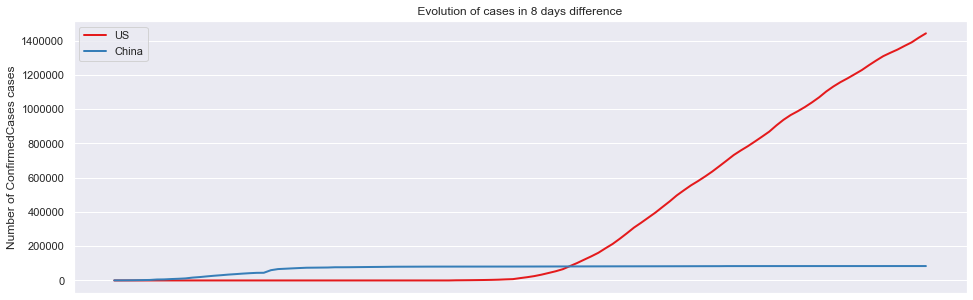

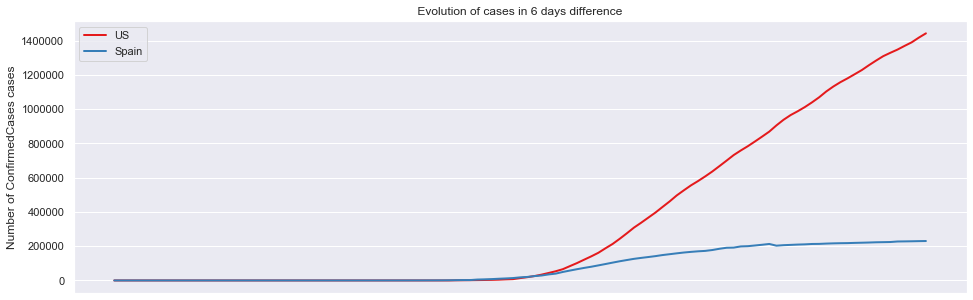

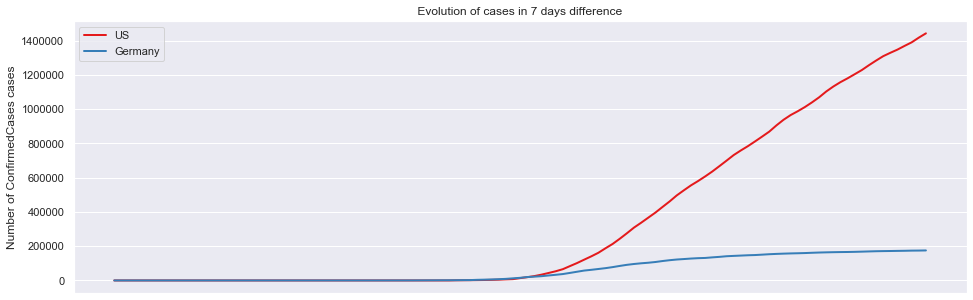

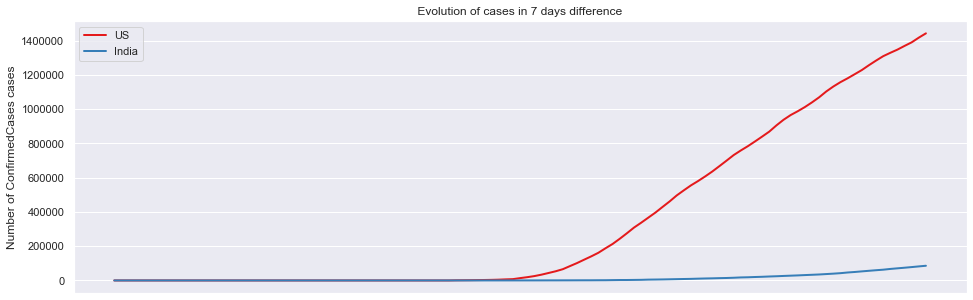

In [124]:
timeCompare(8,'US','China')
timeCompare(6,'US','Spain')
timeCompare(7,'US','Germany')
timeCompare(7,'US','India')

# ARIMA

In [23]:
sns.set(palette = 'Set1',style='darkgrid')
def roll(country,case='ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['ConfirmedCases']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['ConfirmedCases']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case])
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

tsCp = roll('India')

Decomposing the data

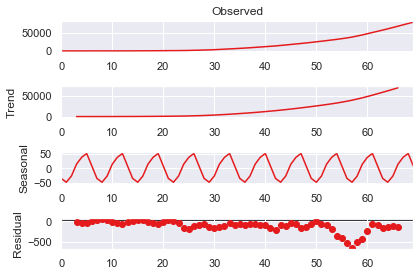

In [136]:
fig=sm.tsa.seasonal_decompose(tsCp.values,freq=7).plot()

Data Stationarity and transformation

In [142]:
#Function to check the stationarity of the time serie using Dickey fuller test
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

#For India
tsC=tsCp['ConfirmedCases'].values
stationarity(tsC)

Results of Dickey-Fuller Test:
Test Statistic                  0.457264
p-value                         0.983515
#Lags Used                      9.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64


AUTO Correlation

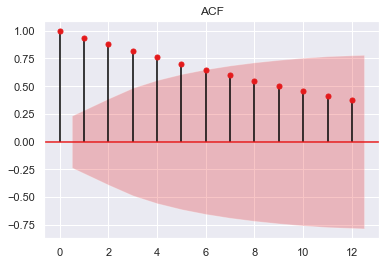

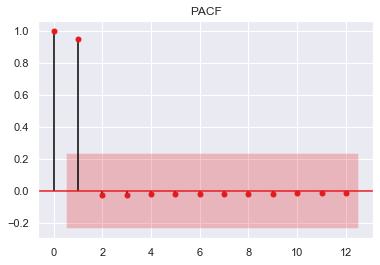

In [148]:
#For India
corr(tsCp)

Model Building

In [153]:
train = train.set_index(['Date'])
test = test.set_index(['Date'])

In [154]:

def create_features(df,label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
   
    return X

In [155]:
train_features=pd.DataFrame(create_features(train))
test_features=pd.DataFrame(create_features(test))
features_and_target_train = pd.concat([train,train_features], axis=1)
features_and_target_test = pd.concat([test,test_features], axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df
features_and_target_train= FunLabelEncoder(features_and_target_train)

In [156]:
x_train= features_and_target_train[['Country_Region','month', 'dayofyear', 'dayofmonth' , 'weekofyear']]
y1 = features_and_target_train[['ConfirmedCases']]
y2 =features_and_target_train[['Fatalities']]
x_test = features_and_target_test[['Country_Region', 'month', 'dayofyear', 'dayofmonth' , 'weekofyear']]


(1, 2, 5)


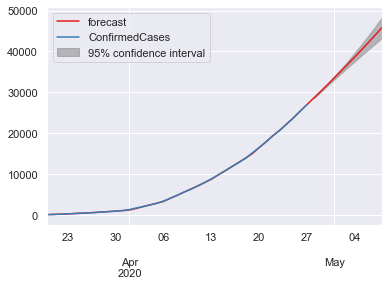

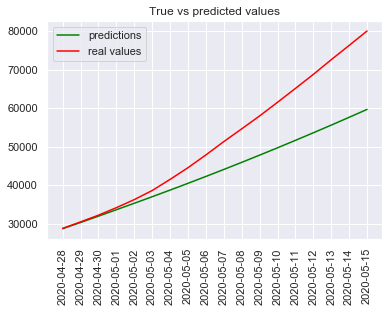

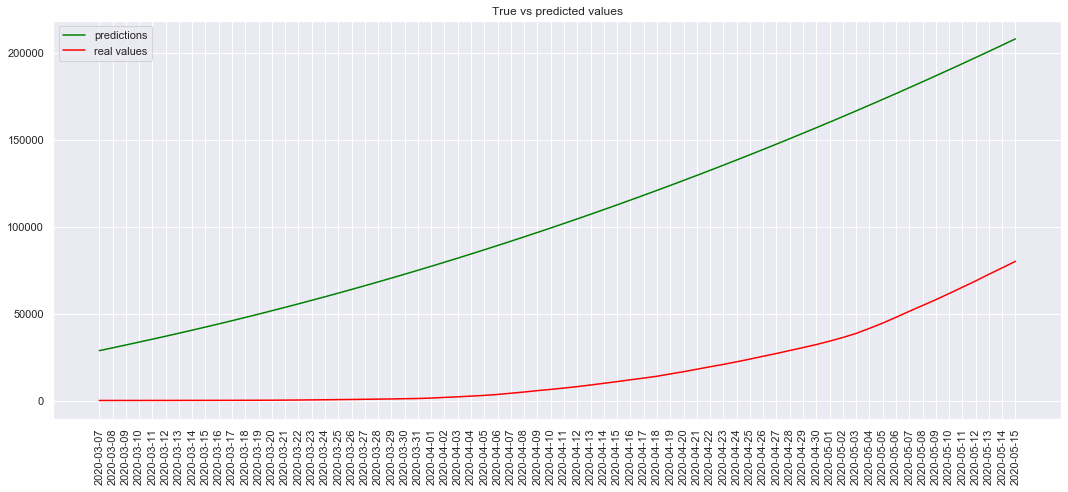

                             ARIMA Model Results                              
Dep. Variable:      D2.ConfirmedCases   No. Observations:                   50
Model:                 ARIMA(1, 2, 5)   Log Likelihood                -264.663
Method:                       css-mle   S.D. of innovations             42.675
Date:                Tue, 19 May 2020   AIC                            545.325
Time:                        18:34:34   BIC                            560.621
Sample:                    03-09-2020   HQIC                           551.150
                         - 04-27-2020                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      30.0209     11.806      2.543      0.011       6.882      53.159
ar.L1.D2.ConfirmedCases     0.3087      0.156      1.976      0.048       0.002       0.615


In [171]:
#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    size = int(len(ts) * 0.50)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test,tsw):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    print(param)
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.25), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    pred1=result.forecast(steps=len(tsw))[0]
    #Plotting results
    f,ax=plt.subplots()
    
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('True vs predicted values')
    plt.show()
    #Plotting results
    f,ax=plt.subplots(figsize=(15,7))
    
    plt.plot(pred1,c='green', label= 'predictions')
    plt.plot(tsw, c='red',label='real values')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('True vs predicted values')
    plt.tight_layout()
    plt.show()
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)



train,test=split(tsCp)
pred=arima(train,test,tsCp)

(4, 2, 3)


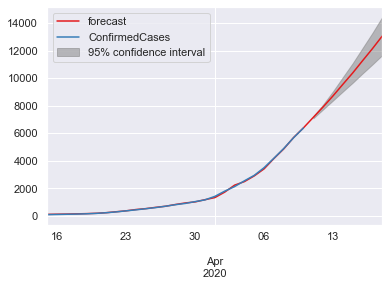

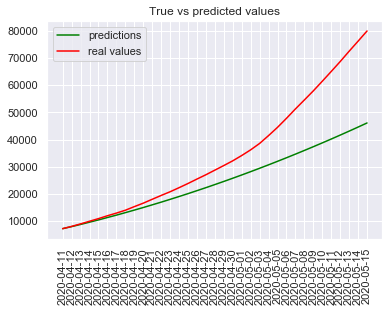

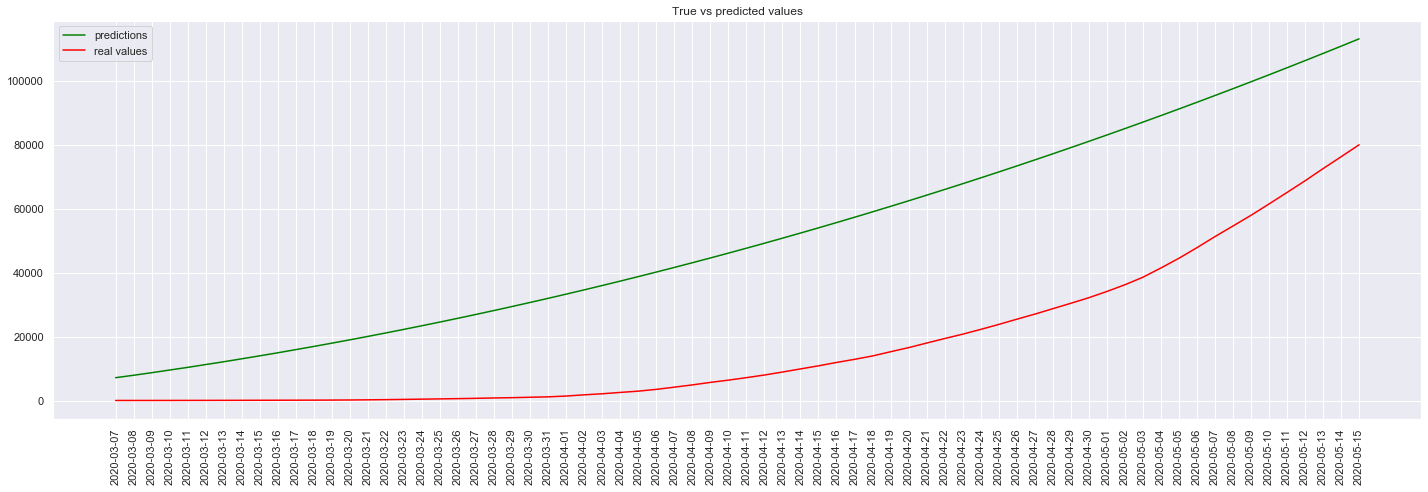

                             ARIMA Model Results                              
Dep. Variable:      D2.ConfirmedCases   No. Observations:                   33
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -167.384
Method:                       css-mle   S.D. of innovations             35.803
Date:                Tue, 19 May 2020   AIC                            352.767
Time:                        23:22:11   BIC                            366.236
Sample:                    03-09-2020   HQIC                           357.299
                         - 04-10-2020                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      22.2924      8.823      2.527      0.018       5.000      39.585
ar.L1.D2.ConfirmedCases    -1.0726      0.242     -4.423      0.000      -1.548      -0.597


In [48]:
#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.70)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test,tsw):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    print(param)
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.25), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    pred1=result.forecast(steps=len(tsw))[0]
    #Plotting results
    f,ax=plt.subplots()
    
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('True vs predicted values')
    plt.show()
    #Plotting results
    f,ax=plt.subplots(figsize=(20,7))
    
    plt.plot(pred1,c='green', label= 'predictions')
    plt.plot(tsw, c='red',label='real values')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('True vs predicted values')
    plt.tight_layout()
    plt.show()
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)



train,test=split(tsCp)
pred=arima(train,test,tsCp)